In [1]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [2]:
classificators = [
    ("LGBMClassifier", LGBMClassifier, SEARCH_SPACE_LGBM, LIGHTGBM_PARAMS),
    ("XGBClassifier", XGBClassifier, SEARCH_SPACE_XGB, XGBOOST_PARAMS),
    ("TABNETClassifier", TabNetClassifier, SEARCH_SPACE_TABNET, TABNET_PARAMS),
]

In [4]:
column_names = ["age", "workclass", "education", "martial_status", "occupation", "relationship",
               "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "TARGET"]

In [4]:
data = pd.read_csv("data/census_income/train.csv", usecols=[0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], names=column_names, header=0)

In [6]:
train = pd.read_csv("data/census_income/train.csv", usecols=[0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], names=column_names, header=0)
valid = pd.read_csv("data/census_income/val.csv", usecols=[0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], names=column_names, header=0)

train_x = train.drop(["TARGET"], axis=1).values
train_y = train["TARGET"].values

valid_x = valid.drop(["TARGET"], axis=1).values
valid_y = valid["TARGET"].values

In [7]:
def BayesianOptimization(clf, params, search_range, model_name):
    def func_gb(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], early_stopping_rounds=10, verbose=0)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 6)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    def func_tabnet(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], max_epochs=30)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 6)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    return func_gb if model_name != "TABNETClassifier" else func_tabnet

In [8]:
results = dict()
for clf_name, clf, search_range, params in classificators:
    res_gp = gp_minimize(BayesianOptimization(clf, params, search_range, clf_name), search_range, n_jobs=-1, verbose=True, n_random_starts=10, n_calls=20)
    results[clf_name] = res_gp
    with open('{}_res_gp_shap_census.pickle'.format(clf_name), 'wb') as f:
        pickle.dump(data, f)

Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.17333210008560201, 'max_depth': 15, 'n_estimators': 903}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.926499  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1140
Function value obtained: -0.9265
Current minimum: -0.9265
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.24085813272210033, 'max_depth': 12, 'n_estimators': 354}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4098
Function value obtained: -0.9279
Current minimum: -0.9282
Iteration No: 16 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4995715139562299, 'max_depth': 10, 'n_estimators': 947}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.925044  of boosting iteration 
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3529
Function value obtained: -0.9250
Current minimum: -0.9282
Iteration No: 17 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3783107183347344,

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.924719  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7715
Function value obtained: -0.9247
Current minimum: -0.9247
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9376184238237958, 'max_depth': 8, 'n_estimators': 753}
[14:07:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.921201  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1414
Function value obtained: -0.9212
Current minimum: -0.9247
Iteration No: 3 started. Evaluating function at random 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.927713  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6022
Function value obtained: -0.9277
Current minimum: -0.9277
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9996018153922194, 'max_depth': 3, 'n_estimators': 672}
[14:07:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.923934  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1971
Function value obtained: -0.9239
Current minimum: -0.9277
Iteration No: 5 started. Evaluating function at random 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


 {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.28802565545305925, 'max_depth': 9, 'n_estimators': 441}
[14:08:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.925402  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3516
Function value obtained: -0.9254
Current minimum: -0.9277
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.15611790283261492, 'max_depth': 8, 'n_estimators': 802}
[14:08:00] WARNING: ../src/learner.cc:541: 
Pa

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.928003  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.6676
Function value obtained: -0.9280
Current minimum: -0.9280
Iteration No: 7 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.13409869155637594, 'max_depth': 7, 'n_estimators': 429}
[14:08:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.928476  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.5570
Function value obtained: -0.9285
Current minimum: -0.9285
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3573510711431971, 'max_depth': 7, 'n_estimators': 810}
[14:08:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.926979  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.2496
Function value obtained: -0.9270
Current minimum: -0.9285
Iteration No: 9 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6584000321144287, 'max_depth': 13, 'n_estimators': 949}
[14:08:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.916903  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.2600
Function value obtained: -0.9169
Current minimum: -0.9285
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6235881748770362, 'max_depth': 5, 'n_estimators': 948}
[14:08:02] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.925312  of boosting iteration 


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.4735
Function value obtained: -0.9253
Current minimum: -0.9285
Iteration No: 11 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1020596894577565, 'max_depth': 3, 'n_estimators': 926}
[14:08:02] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.925721  of boosting iteration 
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.8983
Function value obtained: -0.9257
Current minimum: -0.9285
Iteration No: 12 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10355086976953168, 'max_depth': 15, 'n_estimators': 707}
[14:08:03] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.921941  of boosting iteration 
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 1.4212
Function value obtained: -0.9219
Current minimum: -0.9285
Iteration No: 13 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
[14:08:04] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.928206  of boosting iteration 
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.9872
Function value obtained: -0.9282
Current minimum: -0.9285
Iteration No: 14 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.999319996067456, 'max_depth': 15, 'n_estimators': 111}
[14:08:05] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.914783  of boosting iteration 
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5219
Function value obtained: -0.9148
Current minimum: -0.9285
Iteration No: 15 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4978236771431458, 'max_depth': 3, 'n_estimators': 200}
[14:08:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.925692  of boosting iteration 


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4705
Function value obtained: -0.9257
Current minimum: -0.9285
Iteration No: 16 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9984113902261872, 'max_depth': 11, 'n_estimators': 855}
[14:08:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.915114  of boosting iteration 
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5158
Function value obtained: -0.9151
Current minimum: -0.9285
Iteration No: 17 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9996740731511043, 'max_depth': 5, 'n_estimators': 367}
[14:08:07] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.92148  of boosting iteration 


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5499
Function value obtained: -0.9215
Current minimum: -0.9285
Iteration No: 18 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1000462247463913, 'max_depth': 13, 'n_estimators': 669}
[14:08:07] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.92353  of boosting iteration 
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.5491
Function value obtained: -0.9235
Current minimum: -0.9285
Iteration No: 19 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4897804945684179, 'max_depth': 15, 'n_estimators': 193}
[14:08:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.916986  of boosting iteration 
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.8102
Function value obtained: -0.9170
Current minimum: -0.9285
Iteration No: 20 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
[14:08:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC:  0.928078  of boosting iteration 
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.9127
Function value obtained: -0.9281
Current minimum: -0.9285
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.8582325717022903, 'lambda_sparse': 0.003944753423342207, 'n_steps': 10, 'n_a': 16, 'n_d': 16}
Device used : cpu
epoch 0  | loss: 0.73234 | val_0_auc: 0.53651 |  0:00:06s
epoch 1  | loss: 0.49668 | val_0_auc: 0.65552 |  0:00:12s
epoch 2  | loss: 0.44088 | val_0_auc: 0.56899 |  0:00:18s
epoch 3  | loss: 0.40695 | val_0_auc: 0.75849 |  0:00:24s
epoch 4  | loss: 0.38764 | val_0_auc: 0.79179 |  0:00:31s
epoch 5  | loss: 0.376   | val_0_auc: 0.78999 |  0:00:37s
epoch 6  | loss: 0.38541 | val_0_auc: 0.83451 |  0:00:43s
epoch 7  | loss: 0.39322 | val_0_auc: 0.84269 |  0:00:49s
epoch 8  | loss: 0.40319 | val_0_auc: 0.84299 |  0:00:56s
epoch 9  | loss: 0.41124 | val_0_auc: 0.8457

epoch 16 | loss: 0.3826  | val_0_auc: 0.86069 |  0:05:32s
epoch 17 | loss: 0.37512 | val_0_auc: 0.86676 |  0:05:51s
epoch 18 | loss: 0.37579 | val_0_auc: 0.87034 |  0:06:11s
epoch 19 | loss: 0.37847 | val_0_auc: 0.86391 |  0:06:30s
epoch 20 | loss: 0.37103 | val_0_auc: 0.87225 |  0:06:50s
epoch 21 | loss: 0.36957 | val_0_auc: 0.87376 |  0:07:10s
epoch 22 | loss: 0.36933 | val_0_auc: 0.86758 |  0:07:30s
epoch 23 | loss: 0.36571 | val_0_auc: 0.8714  |  0:07:50s
epoch 24 | loss: 0.36259 | val_0_auc: 0.86988 |  0:08:09s
epoch 25 | loss: 0.35884 | val_0_auc: 0.87799 |  0:08:29s
epoch 26 | loss: 0.36124 | val_0_auc: 0.87255 |  0:08:49s
epoch 27 | loss: 0.3607  | val_0_auc: 0.86874 |  0:09:09s
epoch 28 | loss: 0.36316 | val_0_auc: 0.87337 |  0:09:28s
epoch 29 | loss: 0.36106 | val_0_auc: 0.87423 |  0:09:48s
Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_auc = 0.87799
Best weights from best epoch are automatically used!
AUC:  0.877993  of boosting iterati

epoch 3  | loss: 0.40436 | val_0_auc: 0.7631  |  0:00:12s
epoch 4  | loss: 0.39635 | val_0_auc: 0.79378 |  0:00:15s
epoch 5  | loss: 0.38629 | val_0_auc: 0.83297 |  0:00:19s
epoch 6  | loss: 0.38298 | val_0_auc: 0.83208 |  0:00:22s
epoch 7  | loss: 0.38507 | val_0_auc: 0.84727 |  0:00:25s
epoch 8  | loss: 0.38727 | val_0_auc: 0.85891 |  0:00:28s
epoch 9  | loss: 0.37795 | val_0_auc: 0.87538 |  0:00:32s
epoch 10 | loss: 0.37398 | val_0_auc: 0.8736  |  0:00:35s
epoch 11 | loss: 0.36905 | val_0_auc: 0.86463 |  0:00:38s
epoch 12 | loss: 0.3743  | val_0_auc: 0.87755 |  0:00:41s
epoch 13 | loss: 0.37721 | val_0_auc: 0.86956 |  0:00:44s
epoch 14 | loss: 0.37638 | val_0_auc: 0.87182 |  0:00:48s
epoch 15 | loss: 0.36973 | val_0_auc: 0.87519 |  0:00:51s
epoch 16 | loss: 0.37141 | val_0_auc: 0.86805 |  0:00:54s
epoch 17 | loss: 0.37196 | val_0_auc: 0.86258 |  0:00:57s
epoch 18 | loss: 0.38002 | val_0_auc: 0.85084 |  0:01:00s
epoch 19 | loss: 0.38511 | val_0_auc: 0.85759 |  0:01:03s
epoch 20 | los

AUC:  0.882825  of boosting iteration 
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 249.5357
Function value obtained: -0.8828
Current minimum: -0.8960
Iteration No: 12 started. Searching for the next optimal point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.0, 'lambda_sparse': 0.001, 'n_steps': 10, 'n_a': 8, 'n_d': 8}
Device used : cpu
epoch 0  | loss: 0.55038 | val_0_auc: 0.51015 |  0:00:04s
epoch 1  | loss: 0.4125  | val_0_auc: 0.60838 |  0:00:09s
epoch 2  | loss: 0.39406 | val_0_auc: 0.68138 |  0:00:13s
epoch 3  | loss: 0.39734 | val_0_auc: 0.77699 |  0:00:18s
epoch 4  | loss: 0.3746  | val_0_auc: 0.77833 |  0:00:23s
epoch 5  | loss: 0.36878 | val_0_auc: 0.78183 |  0:00:27s
epoch 6  | loss: 0.36299 | val_0_auc: 0.85283 |  0:00:32s
epoch 7  | loss: 0.35981 | val_0_auc: 0.87288 |  0:00:36s
epoch 8  | loss: 0.36031 | val_0_auc: 0.88242 |  0:00:41s
epoch 9  | loss: 0.35597 | val_0_auc: 0.88643 |  0:00:46s
epoch 10 | los

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epoch 0  | loss: 0.55038 | val_0_auc: 0.51015 |  0:00:04s
epoch 1  | loss: 0.4125  | val_0_auc: 0.60838 |  0:00:09s
epoch 2  | loss: 0.39406 | val_0_auc: 0.68138 |  0:00:14s
epoch 3  | loss: 0.39734 | val_0_auc: 0.77699 |  0:00:19s
epoch 4  | loss: 0.3746  | val_0_auc: 0.77833 |  0:00:24s
epoch 5  | loss: 0.36878 | val_0_auc: 0.78183 |  0:00:28s
epoch 6  | loss: 0.36299 | val_0_auc: 0.85283 |  0:00:33s
epoch 7  | loss: 0.35981 | val_0_auc: 0.87288 |  0:00:37s
epoch 8  | loss: 0.36031 | val_0_auc: 0.88242 |  0:00:42s
epoch 9  | loss: 0.35597 | val_0_auc: 0.88643 |  0:00:47s
epoch 10 | loss: 0.34995 | val_0_auc: 0.88546 |  0:00:51s
epoch 11 | loss: 0.34762 | val_0_auc: 0.8945  |  0:00:56s
epoch 12 | loss: 0.34217 | val_0_auc: 0.89645 |  0:01:00s
epoch 13 | loss: 0.34672 | val_0_auc: 0.89468 |  0:01:05s
epoch 14 | loss: 0.34648 | val_0_auc: 0.89949 |  0:01:09s
epoch 15 | loss: 0.34262 | val_0_auc: 0.89629 |  0:01:14s
epoch 16 | loss: 0.33986 | val_0_auc: 0.90013 |  0:01:18s
epoch 17 | los

epoch 22 | loss: 0.34266 | val_0_auc: 0.89346 |  0:00:53s
epoch 23 | loss: 0.33983 | val_0_auc: 0.89322 |  0:00:55s
epoch 24 | loss: 0.34222 | val_0_auc: 0.89574 |  0:00:57s
epoch 25 | loss: 0.34099 | val_0_auc: 0.89491 |  0:01:00s
epoch 26 | loss: 0.34324 | val_0_auc: 0.89643 |  0:01:02s
epoch 27 | loss: 0.33873 | val_0_auc: 0.89592 |  0:01:04s
epoch 28 | loss: 0.33744 | val_0_auc: 0.89619 |  0:01:06s
epoch 29 | loss: 0.33628 | val_0_auc: 0.89663 |  0:01:09s
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.89663
Best weights from best epoch are automatically used!
AUC:  0.896633  of boosting iteration 
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 70.0645
Function value obtained: -0.8966
Current minimum: -0.9062
Iteration No: 18 started. Searching for the next optimal point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.0530211946353565, 'lambda_sparse': 0.001, 'n_steps': 9, 'n

# Partial dataset (with no fnlwgt and education_num)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

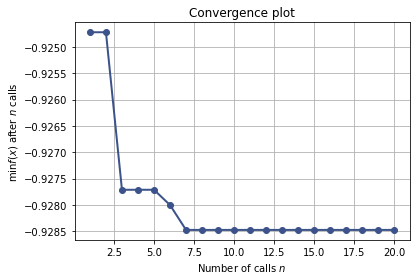

In [9]:
plot_convergence(results["XGBClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

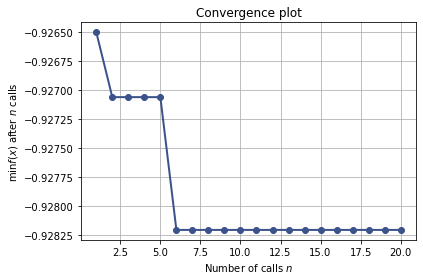

In [10]:
plot_convergence(results["LGBMClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

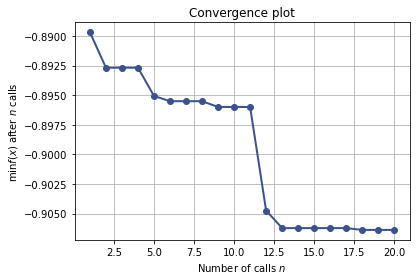

In [11]:
plot_convergence(results["TABNETClassifier"])

In [12]:
results["LGBMClassifier"].x

[0.13757478161712752, 7, 311]

In [13]:
results["XGBClassifier"].x

[0.13409869155637594, 7, 429]

In [14]:
results["TABNETClassifier"].x

[1.0530211946353565, 0.001, 9, 64]

# Full dataset

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

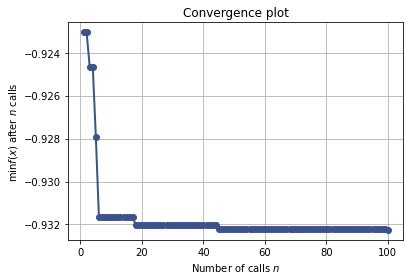

In [13]:
plot_convergence(results["XGBClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

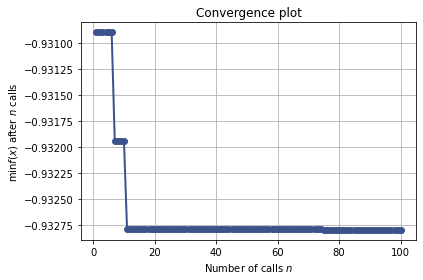

In [14]:
plot_convergence(results["LGBMClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

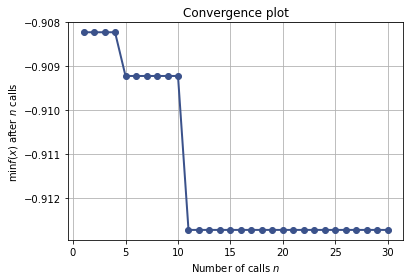

In [15]:
plot_convergence(results["TABNETClassifier"])

In [15]:
results["LGBMClassifier"].x

[0.10284216487315759, 4, 955]

In [16]:
results["XGBClassifier"].x

[0.3317433223693123, 4, 772]

In [16]:
results["TABNETClassifier"].x

[1.0131059206061017, 0.0051151725754103195, 10, 54]